# **"Shirt Color Prediction Using YOLOv8"**

### The purpose of this notebook is to train the YOLOv8 model for shirt color prediction on Custom shirt data

#### **Libraries Used:**
>ultralytics

>shutil

#### **What is ultralytics library?**
>Ultralytics is a library for object detection, segmentation, and instance segmentation. It is used for image and video analysis.

#### **How to use?**

>1. Anotate Data: Our data has 4 classes (black, blue, grey, white). Each class had 150 images which were anotated using CVAT.ai website and the data (.txt files) were stored in a folder.

>2. Upload Data to Drive

>3. Mount Drive on Colab

>4. Install ultralytics

>5. Make a yaml file of your custom dataset to provide it to model

>6. Train YOLOv8 nano on custom dataset

>7. Copy the model results to Drive

>8. Use a script to test model on vscode


# +_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+

## **Mount Drive to Colab**

In [1]:
from google.colab import drive

# Attempt to mount Google Drive with a longer timeout
drive.mount('/content/gdrive', force_remount=True, timeout_ms=120000)

Mounted at /content/gdrive


## **Data Augmentation**

In [2]:
!pip install albumentations opencv-python

#### **This code snippet creates new folders for augmented images and respective labels on the mounted drive**
#### The Augmentations performed are:
> Horizontal Flip

> Rotation: Used because person in real life might not be fully upfront of camera

> Shear: A shear to create a compressed or shrunken image

> Gaussian Noise: To add a effect of sensor noise

> MotionBlur: To add motion blur caused by camera

> Brightness Contrast: To create an effect of different lightning conditions

#### The Augmented images will be saved in the folders.

In [3]:
import os
import cv2
import albumentations as A
from glob import glob

# Create directories for augmented data
augmented_images_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/augmented/images/train'
augmented_labels_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/augmented/labels/train'

os.makedirs(augmented_images_path, exist_ok=True)
os.makedirs(augmented_labels_path, exist_ok=True)

# Define augmentations
transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=(-15, 15), p=0.5),  # Rotate between -15 and 15 degrees
        A.Affine(shear=5, p=0.5),  # Slight shear 
    ], p=1),  # One of these will definitely be applied

    A.OneOf([
        A.GaussNoise(p=0.5),  # Add noise with 50% probability
        A.MotionBlur(blur_limit=3, p=0.5),  # Motion blur with 50% probability
    ], p=1),  # One of these will definitely be applied

    A.RandomBrightnessContrast(
        brightness_limit=0.1,  # ±10%
        contrast_limit=0.1,    # ±10%
        p=0.5),

], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))  # Specify how to handle bboxes

# Paths to your images and labels
images_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/images/train'
labels_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/labels/train'

# Define the image extensions you want to include
image_extensions = ['.jpg', '.jpeg', '.png', '.webp']

# Collect all image files with the specified extensions
images = []
for ext in image_extensions:
    images.extend(glob(os.path.join(images_path, f'*{ext}')))

for image_path in images:
    # Load image
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path)
    label_name = os.path.splitext(image_name)[0] + '.txt'

    # Load corresponding label
    label_path = os.path.join(labels_path, label_name)
    if not os.path.exists(label_path):
        continue

    # Read label file
    with open(label_path, 'r') as f:
        bboxes = []
        class_labels = []  # To store class labels for each bbox
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            bboxes.append([x_center, y_center, width, height])
            class_labels.append(int(class_id))

    # Save the original image and label
    original_image_path = os.path.join(augmented_images_path, image_name)
    cv2.imwrite(original_image_path, image)

    original_label_path = os.path.join(augmented_labels_path, label_name)
    with open(original_label_path, 'w') as f:
        for bbox, class_id in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

    for i in range(3):  # Apply augmentations 3 times
        # Apply augmentations
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)  # Pass class labels
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']  # Get transformed class labels

        # Save augmented image
        augmented_image_path = os.path.join(augmented_images_path, f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg")
        cv2.imwrite(augmented_image_path, transformed_image)

        # Save augmented labels
        augmented_label_path = os.path.join(augmented_labels_path, f"{os.path.splitext(label_name)[0]}_aug_{i}.txt")
        with open(augmented_label_path, 'w') as f:
            for bbox, class_id in zip(transformed_bboxes, transformed_class_labels):
                x_center, y_center, width, height = bbox
                f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

print("Augmentation completed.")

Augmentation completed.


### **Randomly plot 15 images from the augmented data**

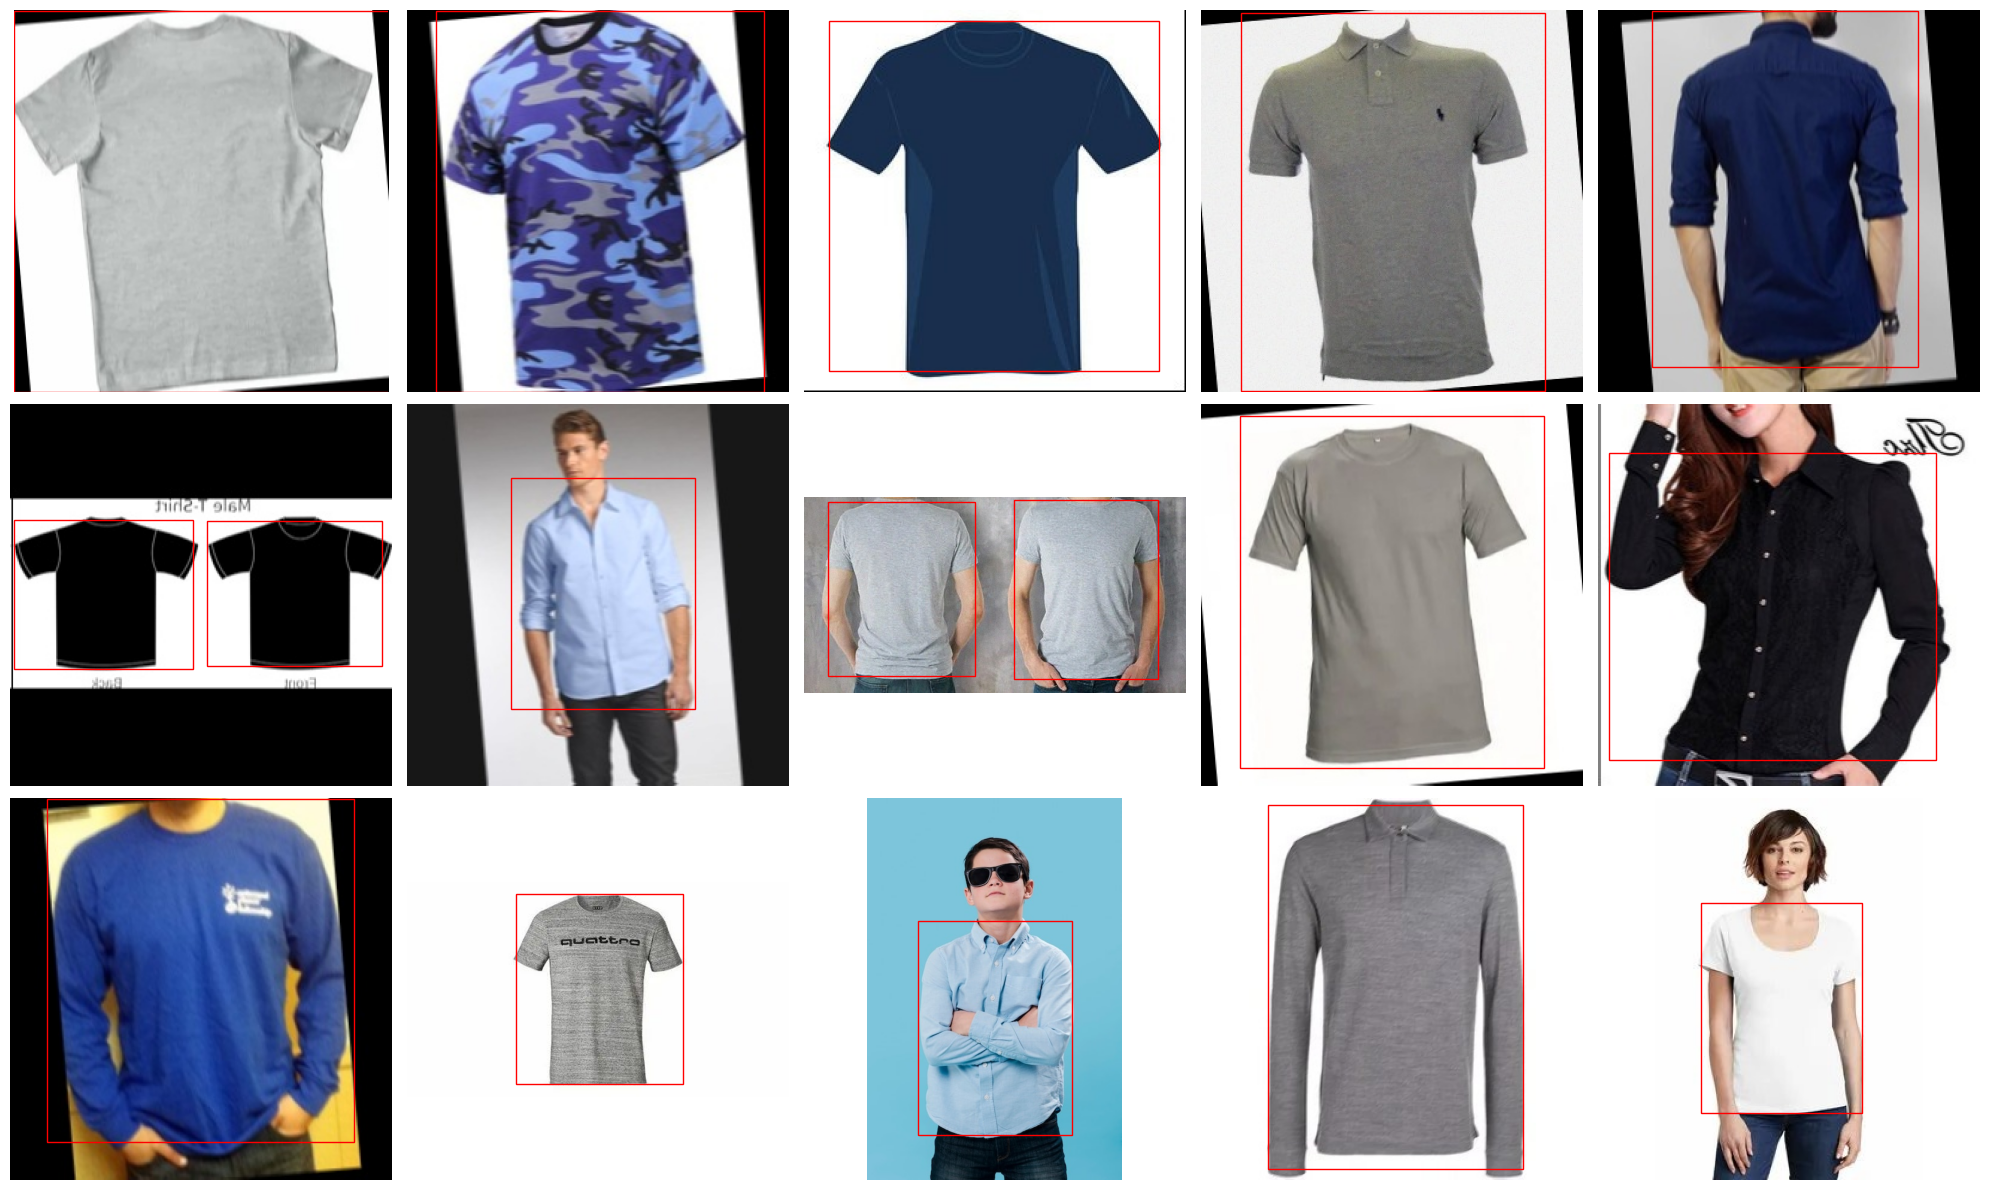

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from random import sample

def plot_image_with_bboxes(ax, image, bboxes):
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for bbox in bboxes:
        x_center, y_center, width, height, class_id = bbox
        # Convert from relative to absolute coordinates
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        rect_width = int(width * image.shape[1])
        rect_height = int(height * image.shape[0])

        rect = patches.Rectangle((x_min, y_min), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.axis('off')  # Hide the axes

# Paths to your augmented images and labels
images_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/augmented/images/train'
labels_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/augmented/labels/train'

# Collect all image files
image_files = glob(os.path.join(images_path, '*.*'))  # Wildcard for all extensions

# Randomly select 15 images
sample_images = sample(image_files, 15)

# Set up the subplot grid
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust figsize as needed
axes = axes.flatten()

for i, image_path in enumerate(sample_images):
    # Load image
    image = cv2.imread(image_path)

    # Check if the image was loaded properly
    if image is None:
        print(f"Error loading image: {image_path}")
        continue

    # Load corresponding label
    label_name = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
    label_path = os.path.join(labels_path, label_name)

    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                bboxes.append([x_center, y_center, width, height, int(class_id)])

    # Plot image with bounding boxes
    plot_image_with_bboxes(axes[i], image, bboxes)

# Hide any unused subplots
for j in range(len(sample_images), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### **Data count after augmentation**

In [5]:
import os

def count_images_in_folder(folder_path, image_extensions):
    # Initialize count
    image_count = 0

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file has an image extension
        if any(file_name.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

# Define the path to your folder and the image extensions to look for
folder_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/augmented/images/train'
image_extensions = ['.jpg', '.jpeg', '.png', '.webp']

# Get the count of images
num_images = count_images_in_folder(folder_path, image_extensions)

print(f"Number of images in the folder: {num_images}")

Number of images in the folder: 2124


## **Set the root directory path**

In [3]:
ROOT_DIR = '/content/gdrive/My Drive/Train_YOLOv8_custom_datset'

## **Install ultralytics**

In [4]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

## **Train the model**

In [5]:
import os

from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "google_colab_config.yaml"), epochs=20)

Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/gdrive/My Drive/Train_YOLOv8_custom_datset/google_colab_config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

100%|██████████| 755k/755k [00:00<00:00, 35.1MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 171MB/s]


AMP: checks passed ✅


train: Scanning /content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/augmented/labels/train.cache... 2124 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2124/2124 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/gdrive/MyDrive/Train_YOLOv8_custom_datset/data/labels/val.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.28G       2.83      3.796      3.929         40        640: 100%|██████████| 133/133 [01:40<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         66         67      0.367      0.394     0.0504     0.0193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.26G      2.214      3.174      3.017         26        640: 100%|██████████| 133/133 [00:55<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         66         67      0.495      0.551      0.403      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.26G      1.742      2.427      2.411         33        640: 100%|██████████| 133/133 [00:56<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         66         67      0.786      0.582      0.762      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.25G      1.518      2.008      2.157         36        640: 100%|██████████| 133/133 [00:55<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66         67        0.8      0.778      0.844      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.26G      1.357      1.735      1.973         28        640: 100%|██████████| 133/133 [00:54<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66         67      0.752      0.879      0.907      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.25G      1.274      1.536      1.872         40        640: 100%|██████████| 133/133 [00:56<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


                   all         66         67      0.792      0.881      0.914      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.25G      1.208      1.378      1.803         36        640: 100%|██████████| 133/133 [00:53<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         66         67        0.8      0.878      0.912      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.25G       1.15      1.296      1.735         36        640: 100%|██████████| 133/133 [00:51<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         66         67      0.912      0.874      0.944       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.26G      1.092      1.222      1.685         32        640: 100%|██████████| 133/133 [00:52<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         66         67      0.949      0.896      0.977      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.25G      1.068      1.132      1.643         32        640: 100%|██████████| 133/133 [00:53<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         66         67       0.87      0.944      0.949      0.696


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.39G       0.82     0.8817      1.496         12        640: 100%|██████████| 133/133 [00:55<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         66         67      0.946      0.923      0.962      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.25G     0.7477     0.7498      1.408         14        640: 100%|██████████| 133/133 [00:53<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         66         67      0.962      0.951      0.965      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.26G     0.7367     0.6878      1.395         12        640: 100%|██████████| 133/133 [00:49<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         66         67      0.899       0.97       0.95      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.25G     0.7204     0.6802      1.376         14        640: 100%|██████████| 133/133 [00:53<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         66         67      0.832      0.869      0.946      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.25G      0.676     0.6359      1.337         13        640: 100%|██████████| 133/133 [00:50<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         66         67      0.941      0.967      0.979      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.25G       0.66     0.5946      1.306         15        640: 100%|██████████| 133/133 [00:49<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         66         67      0.954      0.955      0.971      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.26G     0.6298     0.5476      1.276         12        640: 100%|██████████| 133/133 [00:52<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         66         67      0.991      0.901      0.977      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.25G     0.6052     0.5263       1.25         12        640: 100%|██████████| 133/133 [00:52<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         66         67      0.946      0.966      0.978      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.25G     0.5769     0.4973      1.242         14        640: 100%|██████████| 133/133 [00:46<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         66         67      0.954       0.94      0.972      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.25G     0.5742     0.4713      1.214         12        640: 100%|██████████| 133/133 [00:50<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         66         67      0.971      0.912      0.972      0.855



20 epochs completed in 0.323 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


                   all         66         67      0.965      0.946      0.977      0.856
            blue shirt         22         22      0.952      0.909      0.954      0.855
           white shirt         22         22      0.944          1      0.993       0.87
           black shirt         22         23          1       0.93      0.985      0.843
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train


## **Upload results to drive**

In [6]:
import shutil
source_path = '/content/runs/'
destination_path = '/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/runs_backup_4'
shutil.copytree(source_path, destination_path)

'/content/gdrive/MyDrive/Train_YOLOv8_custom_datset/runs_backup_4'